In [1]:
# Here we compute the different statistics regarding the spatial data
# Before preprocessing and PT calculation:
# - Cancer Grade Spots per Sample
# - Total Number of Spots
# - Total Number of Epithelial Spots
# - Average Number of Spots per Sample
# - Average Number of Epithelial Spots per Sample
# - Average of unique genes per spot
# - Average of unique genes per spot for the epithelial spots

# After preprocessing and PT calculation:
# - Total Number od Spots
# - Average Number of Spots per Sample
# - Average Number of Unique Genes per Spot

# About the sammples
# - Statistics about highly correlated genes in every sample

# Input Files:
# - CSVs with the samples annotations
# - h5ad files with the spots and genes information
# - _summary_Genes_AllSpotsPseudotime.csv files containing the gene correlations for every sample

In [2]:
import stlearn as st
import scanpy as sc
import pandas as pd
import re
import numpy as np

from collections import Counter
from scipy.sparse import csr_matrix
import anndata as ad
import seaborn as sns
#import harmonypy as hm
from matplotlib import pyplot as plt
from stlearn.spatials.clustering import localization
from scipy.stats import spearmanr

import gseapy as gp
from matplotlib.colors import LogNorm


plt.rcParams['figure.figsize'] = [6, 6]

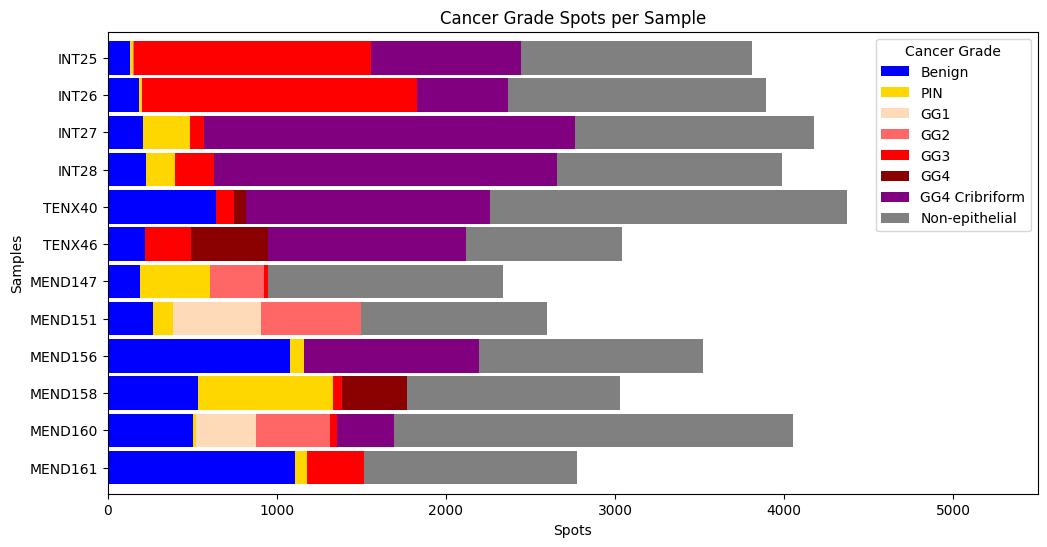

In [19]:
samples = ['INT25','INT26','INT27','INT28','TENX40','TENX46','MEND147','MEND151','MEND156','MEND158','MEND160','MEND161']
input_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'
category_order = ['Benign', 'PIN', 'GG1', 'GG2', 'GG3', 'GG4', 'GG4 Cribriform', 'Non-epithelial']  # Desired order of categories
colors = ['blue', 'gold', 'peachpuff', '#FF6666', 'red', 'darkred', 'purple', 'gray']

result_df = None
for sample in samples:
    CNV = pd.read_csv(input_path + sample + '_annotated2.csv', index_col = 0)
    labels = pd.Series(CNV["Label"].values).value_counts(dropna=False)
    labels.index = labels.index.astype(str).str.replace('GG4cribriform', 'GG4 Cribriform')
    data = pd.DataFrame({
        'Annotations': labels
    }).fillna(0)

    temp_df = data.rename(columns={'Annotations': sample})
    if result_df is None:
            result_df = temp_df
    else:
        result_df = result_df.join(temp_df, how='outer')

result_df.index = result_df.index.astype(str).str.replace('nan', 'Non-epithelial')
result_df = result_df.reindex(category_order, fill_value=0)

final_result = result_df.T.iloc[::-1]

final_result.plot(kind='barh', stacked=True, figsize=(12, 6), color = colors, width = 0.9)
plt.xlabel('Spots')
plt.ylabel('Samples')
plt.title('Cancer Grade Spots per Sample')
plt.legend(title='Cancer Grade')
plt.xlim(0,5500)
plt.savefig('Cancer_Grade_Spots_per_Samples.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
final_result

,Benign,PIN,GG1,GG2,GG3,GG4,GG4 Cribriform,Non-epithelial
MEND161,1106.0,74.0,NaN,NaN,338.0,NaN,NaN,1257.0
MEND160,505.0,15.0,354.0,441.0,42.0,NaN,336.0,2358.0
MEND158,535.0,798.0,NaN,NaN,54.0,383.0,NaN,1261.0
MEND156,1079.0,81.0,NaN,NaN,NaN,NaN,1037.0,1324.0
MEND151,270.0,113.0,526.0,591.0,NaN,NaN,NaN,1100.0
MEND147,188.0,415.0,NaN,322.0,24.0,NaN,NaN,1386.0
TENX46,223.0,NaN,NaN,NaN,267.0,456.0,1172.0,925.0
TENX40,639.0,NaN,NaN,NaN,105.0,72.0,1443.0,2112.0
INT28,227.0,170.0,NaN,NaN,229.0,NaN,2030.0,1334.0
INT27,209.0,275.0,NaN,NaN,83.0,NaN,2199.0,1410.0


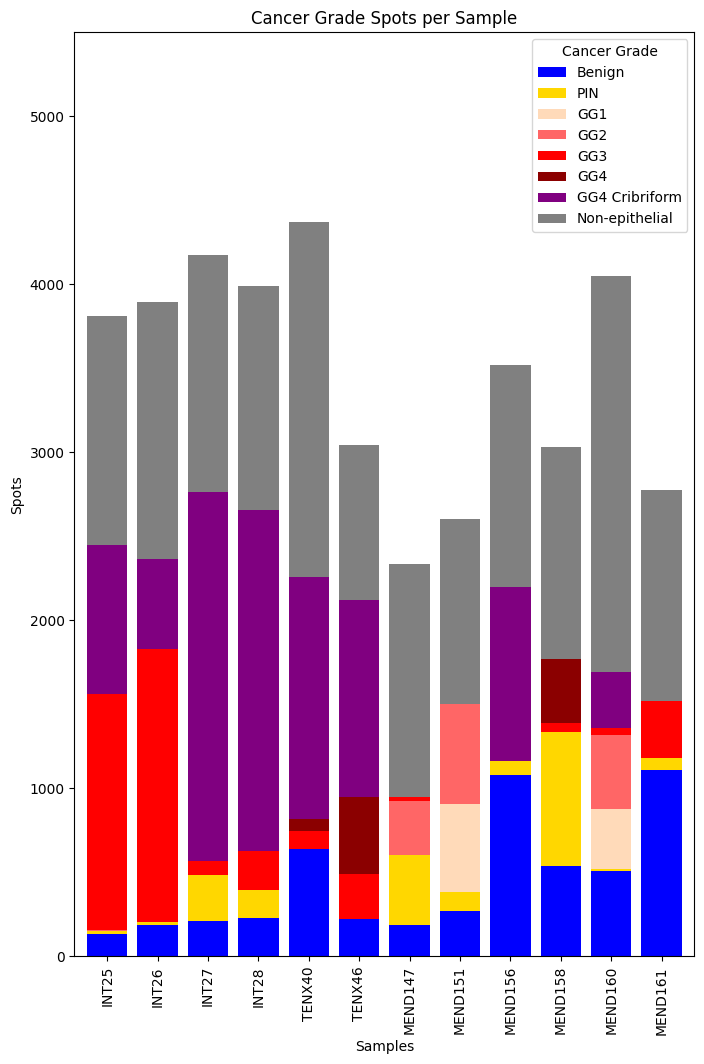

In [4]:
samples = ['INT25','INT26','INT27','INT28','TENX40','TENX46','MEND147','MEND151','MEND156','MEND158','MEND160','MEND161']
input_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'
category_order = ['Benign', 'PIN', 'GG1', 'GG2', 'GG3', 'GG4', 'GG4 Cribriform', 'Non-epithelial']  # Desired order of categories
colors = ['blue', 'gold', 'peachpuff', '#FF6666', 'red', 'darkred', 'purple', 'gray']

result_df = None
for sample in samples:
    CNV = pd.read_csv(input_path + sample + '_annotated2.csv', index_col=0)
    labels = pd.Series(CNV["Label"].values).value_counts(dropna=False)
    labels.index = labels.index.astype(str).str.replace('GG4cribriform', 'GG4 Cribriform')
    data = pd.DataFrame({
        'Annotations': labels
    }).fillna(0)

    temp_df = data.rename(columns={'Annotations': sample})
    if result_df is None:
        result_df = temp_df
    else:
        result_df = result_df.join(temp_df, how='outer')

result_df.index = result_df.index.astype(str).str.replace('nan', 'Non-epithelial')
result_df = result_df.reindex(category_order, fill_value=0)

# Keep the original sample order (no iloc[::-1])
final_result = result_df.T  # No reversing of the order

# Create the vertical bar plot with narrower bars and increased figure height
final_result.plot(kind='bar', stacked=True, figsize=(8, 12), color=colors, width=0.8)  # Adjust width to make bars closer

# Swap axis labels
plt.ylabel('Spots')  # Y-axis represents spots
plt.xlabel('Samples')  # X-axis represents samples
plt.title('Cancer Grade Spots per Sample')
plt.legend(title='Cancer Grade')

# Adjust the y-limit since the bars are now vertical
plt.ylim(0, 5500)

# Save and show the plot
plt.savefig('Cancer_Grade_Spots_per_Samples_vertical.png', dpi=300, bbox_inches='tight')
plt.show()


In [5]:
print("Epithelial spots")
final_result.drop(columns="Non-epithelial").sum().sum()

Epithelial spots


24238.0

In [6]:
print("Total spots")
final_result.sum().sum()

Total spots


41595.0

In [7]:
print("Spots per Sample")
final_result.sum(axis = 1).mean()

Spots per Sample


3466.25

In [8]:
print("Epithelial Spots per Sample")
final_result.drop(columns="Non-epithelial").sum(axis = 1).mean()

Epithelial Spots per Sample


2019.8333333333333

In [9]:
samples = ['INT25','INT26','INT27','INT28','TENX40','TENX46','MEND147','MEND151','MEND156','MEND158','MEND160','MEND161']
input_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'
n_genes = 0
n_genes_labelled = 0
for sample in samples:
    adata = sc.read_h5ad(input_path + sample + '.h5ad')
    n_genes += adata.obs['n_genes_by_counts'].sum()

    CNV = pd.read_csv(input_path + sample + '_annotated2.csv', index_col = 0)
    CNV.columns = ['barcode', 'Label']
    
    adata.obs['Label_orig'] = CNV['Label']
    adata = adata[~adata.obs['Label_orig'].isna()]
    n_genes_labelled += adata.obs['n_genes_by_counts'].sum()

print("Average of unique genes per spot")
print(n_genes/final_result.sum().sum())
print("Average of unique genes per spot for the epithelial spots")
print(n_genes_labelled/final_result.drop(columns="Non-epithelial").sum().sum())

Average of unique genes per spot
3682.398846015146
Average of unique genes per spot for the epithelial spots
4384.718994966582


# Count After Preprocessing and After PseudoTime

In [10]:
# Function to remove outliers
def remove_outliers_function(df, outliers_percentage = 0.02):
    # Calculate th§e lower and upper percentile for each column
    lower_percentile = df.quantile(outliers_percentage/2)
    upper_percentile = df.quantile(1- outliers_percentage/2)
    
    # Filter the DataFrame to keep only the rows within the percentiles
    df_filtered = df.apply(lambda x: x[(x >= lower_percentile[x.name]) & (x <= upper_percentile[x.name])])
    
    # Drop rows with any NaN values (which were outliers)
    df_filtered = df_filtered.dropna()
    
    return df_filtered

def preprocess(adata, louvain_resolution, n_top_genes = 2000, n_comps = 50, diffmap = True, remove_outliers = True, scale = True, outliers_percentage = 0.02):
    """
    Preprocess the data. Be carefull about the order in which diffmap is called relative to other functions
    """

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    # Keep raw data
    adata.raw = adata
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)

    if scale == True:
        sc.pp.scale(adata)

    
    sc.pp.pca(adata, n_comps = n_comps, random_state=0)

    if remove_outliers == True:
        PCs = pd.DataFrame(adata.obsm['X_pca'])
        PCs.index = adata.obs_names
        non_outliers = remove_outliers_function(PCs, outliers_percentage = outliers_percentage).index
        adata = adata[non_outliers]    
        sc.pp.pca(adata, n_comps = n_comps, random_state=0)

    sc.pp.neighbors(adata, use_rep="X_pca", random_state=0)

    if diffmap == True:
        sc.tl.diffmap(adata, n_comps = n_comps, random_state=0)
        sc.pp.neighbors(adata, use_rep="X_diffmap", random_state=0)
        
    st.tl.clustering.louvain(adata,random_state=0, resolution = louvain_resolution)

    return adata

def filter_cells(adata, obs_name, threshold):
    """
    Rename the clusters to fix their bug that the clusters need to be called 0,1,2,3,...
    """
    counts = adata.obs[obs_name].value_counts()
    filtered_categories = counts[counts >= threshold].index
    adata = adata[adata.obs[obs_name].isin(filtered_categories)]

    return(adata)

def get_rank_cor_drug(adata, screening_genes=None):
    
    tmp = adata.uns['drug2cell'].copy()
    tmp = tmp.to_df()
    tmp.columns = list(adata.uns['drug2cell'].var.index)

    if screening_genes != None:
        tmp = tmp[screening_genes]
    dpt = adata.obs["dpt_pseudotime"].values
    drugs = []
    score = []
    pvalue = []
    for drug in list(adata.uns['drug2cell'].var.index):
        drugs.append(drug)
        score.append(spearmanr(tmp[drug].values, dpt)[0])
        pvalue.append(spearmanr(tmp[drug].values, dpt)[1])
    import pandas as pd

    final = pd.DataFrame({"drug": drugs, "score": score, "p-value": pvalue})
    return final

def get_rank_cor_drug_pseudotime(adata, screening_genes=None):
    
    tmp = tmp = adata.to_df()

    if screening_genes != None:
        tmp = tmp[screening_genes]
    
    dpt = adata.obs["dpt_pseudotime"].values
    genes = []
    score = []
    pvalue = []
    for gene in list(adata.var.index):
        genes.append(gene)
        score.append(spearmanr(tmp[gene].values, dpt)[0])
        pvalue.append(spearmanr(tmp[gene].values, dpt)[1])
    import pandas as pd

    final = pd.DataFrame({"gene": genes, "score": score, "p-value": pvalue})
    return final


def detect_pseudotime_markers_total(
    adata,
    use_label,
    cutoff_spearman=0.4,
    cutoff_pvalue=0.05,
    screening_genes=None,
    use_raw_count=False,
    GenesOrDrugs = "genes"
):
    """\
    Detect the genes driving pseudotime

    Parameters
    ----------
    adata
        Annotated data matrix.
    cutoff_spearman
        The threshold of correlation coefficient.
    cutoff_pvalue
        The threshold of p-value.
    screening_genes
        List of customised genes.
    use_raw_count
        True if user wants to use raw layer data.
    Returns
    -------
    Anndata
    """
    print(
        "Detecting the pseudotime markers"
    )
    query_adata = adata[adata.obs[use_label].notna(), :]

    if(GenesOrDrugs == 'drugs'):
        spearman_result = get_rank_cor_drug(
            query_adata, screening_genes=screening_genes
        )
        spearman_result = spearman_result[spearman_result["p-value"] < cutoff_pvalue]
        positive = spearman_result[spearman_result["score"] >= cutoff_spearman].sort_values(
            "score", ascending=False
        )
        negative = spearman_result[
            spearman_result["score"] <= cutoff_spearman * (-1)
        ].sort_values("score")
    
        result = pd.concat([positive, negative])
    
        adata.uns["corr_pseudotime_drugs"] = result
    
        print(
            "Transition drugs markers result is stored in adata.uns[corr_pseudotime]"
        )
    else:
        spearman_result = get_rank_cor_drug_pseudotime(
            query_adata, screening_genes=screening_genes
        )

        spearman_result = spearman_result[spearman_result["p-value"] < cutoff_pvalue]
        positive = spearman_result[spearman_result["score"] >= cutoff_spearman].sort_values(
            "score", ascending=False
        )
        negative = spearman_result[
            spearman_result["score"] <= cutoff_spearman * (-1)
        ].sort_values("score")
    
        result = pd.concat([positive, negative])
    
        adata.uns["corr_pseudotime"] = result
    
        print(
            "Transition gene markers result is stored in adata.uns[corr_pseudotime]"
        )



C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr
C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: Impli

Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr
C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: Impli

Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr
C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr
C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr
C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: Impli

Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr
C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: Impli

Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr
C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: Impli

Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr
C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: Impli

Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr
C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: Impli

Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr
C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: Impli

Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr
C:\Users\dandia\AppData\Local\Temp\ipykernel_6292\382447617.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: Impli

Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\tools\_paga.py:121: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['paga'] = {}
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr


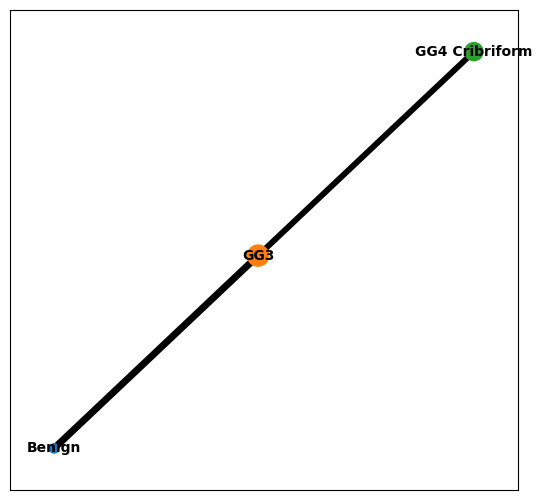

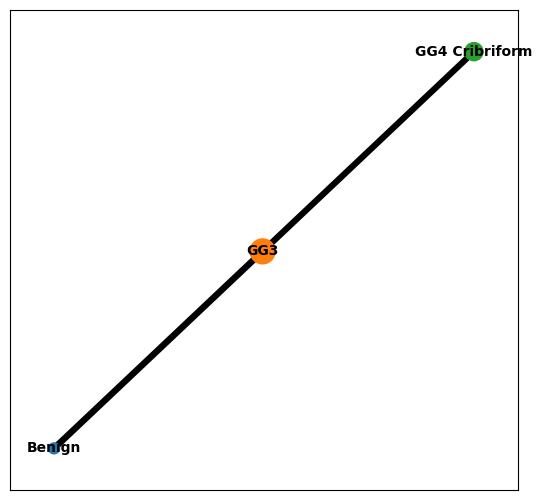

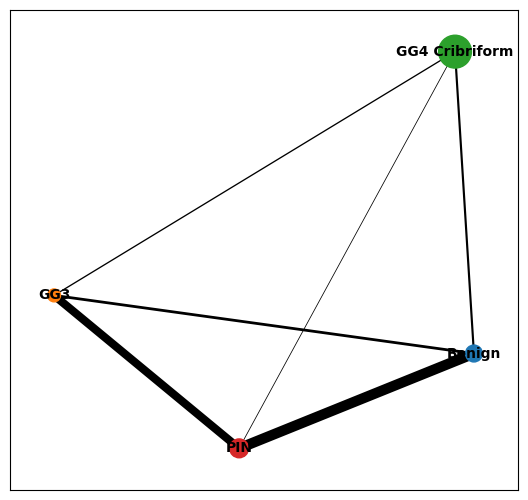

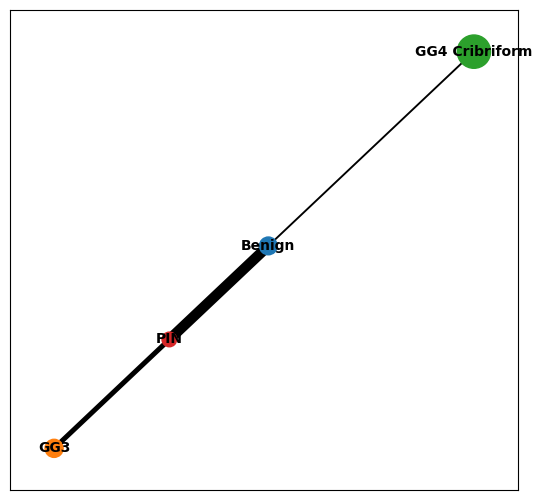

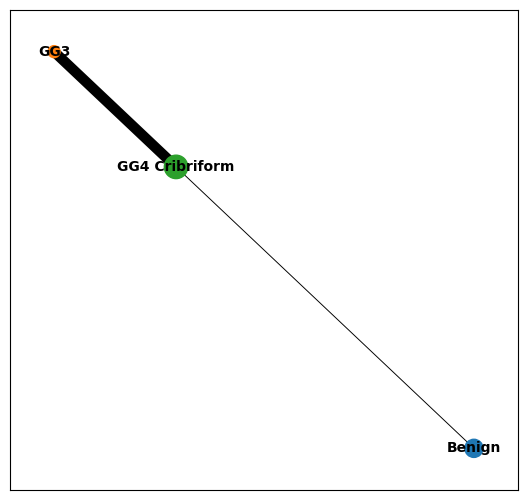

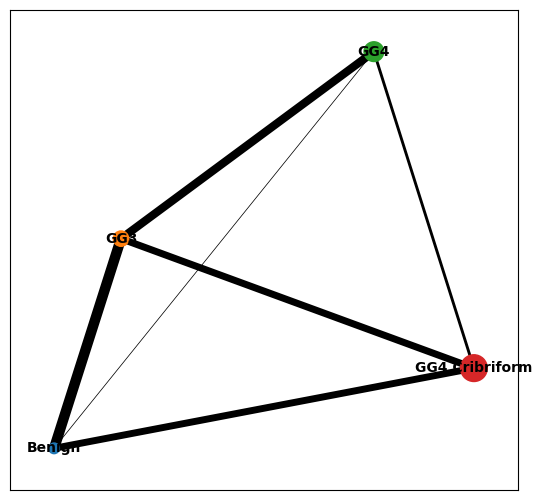

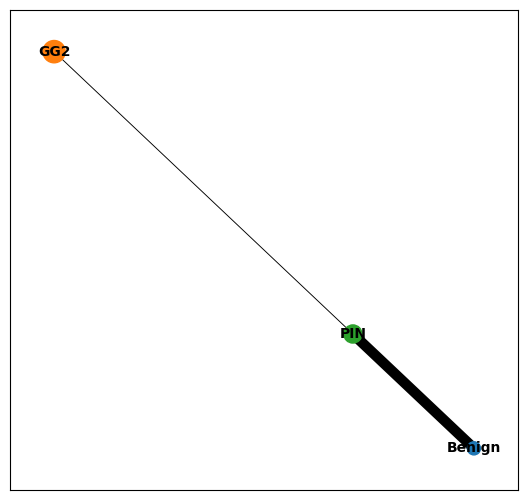

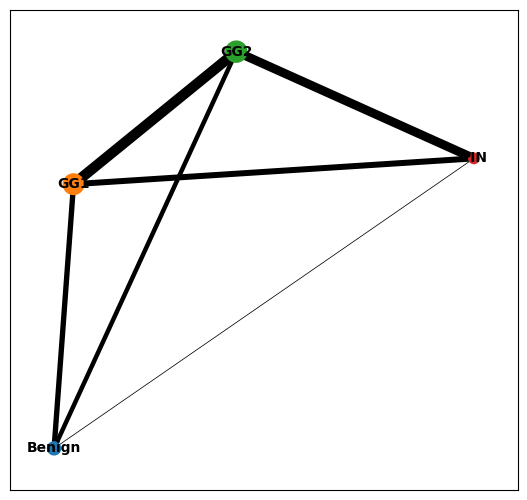

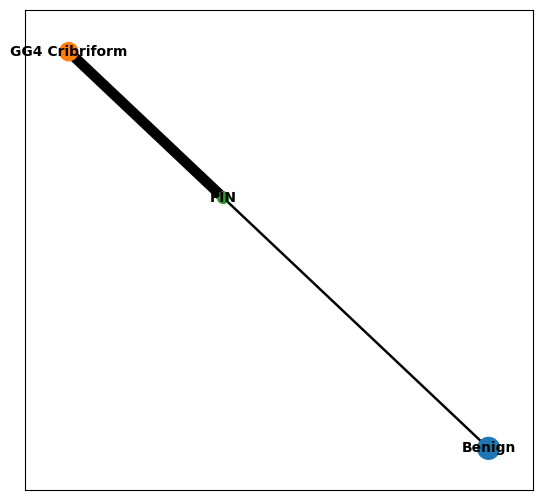

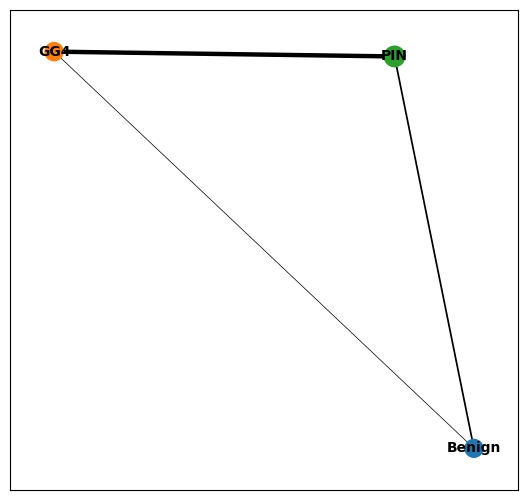

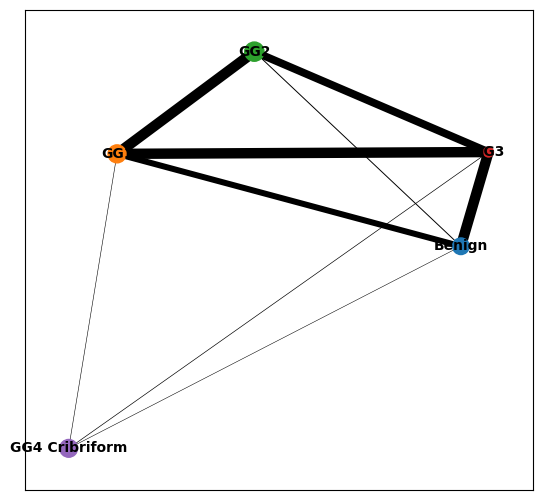

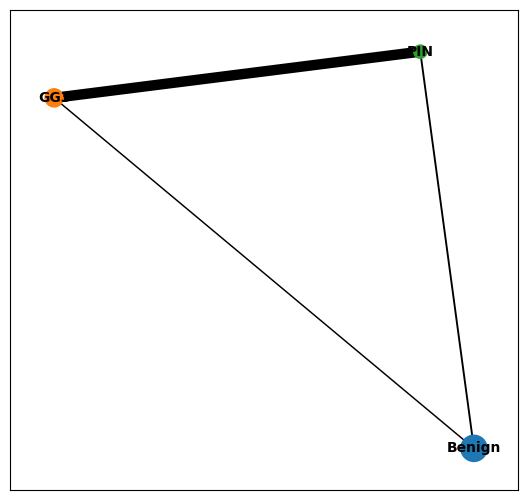

In [11]:
input_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'

n_comps = 10
n_top_genes = None
outliers_percentage = 0.005
diffmap = True # If true, we run diffmap with the same amount of n_comps as we have in PCA, otherwise diffmap is used as part of sc.tl.dpt
paga_threshold = 0.05
samples = ['INT25','INT26','INT27','INT28','TENX40','TENX46','MEND147','MEND151','MEND156','MEND158','MEND160','MEND161']

spots = 0
n_genes_by_counts = 0

result_df = None
for sample in samples:
    adata = sc.read_h5ad(input_path + sample + '.h5ad')
    
    CNV = pd.read_csv(input_path + sample + '_annotated2.csv', index_col = 0)
    
    CNV.columns = ['barcode', 'Label']
    
    #CNV['subclone'][CNV['class'] == 'normal'] = 0
    adata.obs['Label_orig'] = CNV['Label']
    adata = adata[~adata.obs['Label_orig'].isna()]
    adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
    category_order = ['Benign', 'PIN', 'GG1', 'GG2', 'GG3', 'GG4', 'GG4 Cribriform', 'Not Labelled']  # Desired order of categories
    colors = ['blue', 'gold', 'peachpuff', '#FF6666', 'red', 'darkred', 'purple', 'gray']
    color_map = {
        'Benign': 'blue',  # Replace with your actual category name and colors
        'PIN': 'gold',
        'GG1': 'peachpuff',
        'GG2': '#FF6666',
        'GG3': 'red',
        'GG4': 'darkred',
        'GG4 Cribriform': 'purple',
        'Not Labelled': 'gray'
    }
    label_orig_colors = [color_map[label] for label in adata.obs['Label_orig'].unique() if label in color_map]
    label_orig_uniq = adata.obs['Label_orig'].unique()
    # Create a custom color map for Label_orig
    custom_color_map = {
        label: color_map[label] for label in label_orig_uniq if label in color_map
    }
    
    
    sc.pp.filter_cells(adata, min_genes = 100)
    sc.pp.filter_genes(adata,min_cells=3)
    
    
    # Remove spots with more than 20% mitochondrial genes --> indicates dead cells
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
    adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
    
    adata.layers['counts']=adata.X.copy()
    
    adata = st.convert_scanpy(adata, use_quality = 'downscaled_fullres').copy()
    
    adata = preprocess(adata, louvain_resolution = 0.5,  n_top_genes = n_top_genes, n_comps = n_comps,
                       diffmap = diffmap, remove_outliers = True, scale = True, outliers_percentage = outliers_percentage)
    eps = 20 #How big subclusters will be created; The lower number the more subclusters
    threshold_spots = 20 #Remove clusters with less then this many spots
    
    adata.obs['Label_orig'] = (adata.obs['Label_orig']).astype('object').astype('category')
    
    localization(adata, use_label='Label_orig', eps=eps)
    adata = filter_cells(adata, 'sub_cluster_labels', threshold = threshold_spots)
    
    root_cluster = 'Benign' # The cluster that corresponds to the early stage of cancer (benign cells)
    sc.tl.paga(adata, groups='Label_orig')
    sc.pl.paga(adata, threshold=paga_threshold, show=False)
    sc.tl.draw_graph(adata, init_pos="paga")
    
    adata.uns["iroot"] = st.spatial.trajectory.set_root(adata,use_label='Label_orig',cluster=root_cluster, use_raw = False)
    
    sc.tl.dpt(adata)
    adata = adata[~np.isinf(adata.obs['dpt_pseudotime'])]
    
    spots += len(adata.obs.index)
    n_genes_by_counts += np.sum(adata.obs["n_genes_by_counts"])

In [12]:
print("Total Spots")
print(spots)
print("Average Number of Spots per Sample")
print(spots/len(samples))
print("Average Number of Unique Genes per Spot")
print(n_genes_by_counts/spots)

Total Spots
19695
Average Number of Spots per Sample
1641.25
Average Number of Unique Genes per Spot
4799.586951002792


# HC genes per Sample

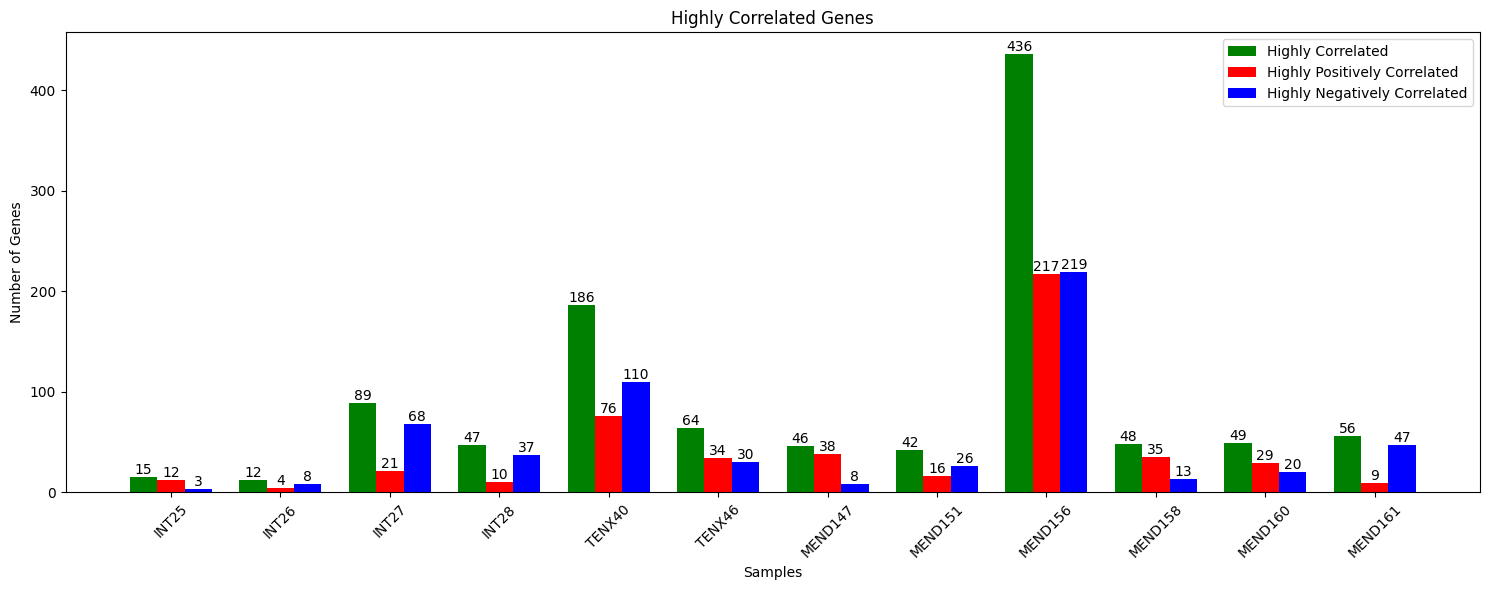

In [13]:
samples = ['INT25','INT26','INT27','INT28','TENX40','TENX46','MEND147','MEND151','MEND156','MEND158','MEND160','MEND161']
threshold = 0.5
result_df = None

for sample in samples:
    data = pd.read_csv('MyPaths/GenesDrugsAllSpots/RemoveTrueTrue/' + sample + '_summary_Genes_AllSpotsPseudotime.csv', index_col = 0)
    data.index = data['gene'].values

    temp_df = data[['score']].rename(columns={'score': sample})
    if result_df is None:
            result_df = temp_df
    else:
        result_df = result_df.join(temp_df, how='outer')


# Step 1: Calculate the number of highly correlated values (|correlation| > 0.5) for each column
highly_correlated_counts = (result_df.abs() > threshold).sum()  # Count values > 0.5 in each column
pos_highly_correlated_counts = (result_df > threshold).sum()  # Count values > 0.5 in each column
neg_highly_correlated_counts = (result_df < -threshold).sum()  # Count values > 0.5 in each column

# Step 3: Plot the bar chart
columns = result_df.columns
x = np.arange(len(columns))  # the label locations
width = 0.25  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))

colorHC = "green" # "blue"
colorHPC = "red" # "skyblue"
colorHNC = "blue" #"lightblue"

# Bar 1: Full highly correlated counts (darker color)
bars1 = ax.bar(x - width, highly_correlated_counts, width, label='Highly Correlated', color=colorHC)

# Bar 2:
bars2 = ax.bar(x, pos_highly_correlated_counts, width, label='Highly Positively Correlated', color=colorHPC)

# Bar 3:
bars3 = ax.bar(x + width, neg_highly_correlated_counts, width, label='Highly Negatively Correlated', color=colorHNC)

# Add labels and title
ax.set_xlabel('Samples')
ax.set_ylabel('Number of Genes')
ax.set_title('Highly Correlated Genes')
ax.set_xticks(x)
ax.set_xticklabels(columns, rotation=45)
ax.legend()

# Add counts on top of the bars
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.savefig('HC_Genes_Per_Samples.png')
plt.show()




In [14]:
highly_correlated_counts

INT25       15
INT26       12
INT27       89
INT28       47
TENX40     186
TENX46      64
MEND147     46
MEND151     42
MEND156    436
MEND158     48
MEND160     49
MEND161     56
dtype: int64

In [18]:
print("Median of number of Highly Correlated genes")
print(np.median(highly_correlated_counts))

print("Q1 of number of Highly Correlated genes")
print(np.percentile(highly_correlated_counts, 25))

print("Q3 of number of Highly Correlated genes")
np.percentile(highly_correlated_counts, 75)

Median of number of Highly Correlated genes
48.5
Q1 of number of Highly Correlated genes
45.0
Q3 of number of Highly Correlated genes


70.25